<a href="https://colab.research.google.com/github/kateemillerhd/predict-health-costs-with-regression/blob/main/Predict_health_costs_with_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

  Preparing metadata (setup.py) ... done
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2025-07-10 01:38:02--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 104.26.2.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv’

insurance.csv       100%[===================>]  49.09K  --.-KB/s    in 0.001s  

2025-07-10 01:38:02 (37.2 MB/s) - ‘insurance.csv’ saved [50264/50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [ ]:
dataset.describe()

,age,bmi,children,expenses
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.665471,1.094918,13270.422414
std,14.049960,6.098382,1.205493,12110.011240
min,18.000000,16.000000,0.000000,1121.870000
25%,27.000000,26.300000,0.000000,4740.287500
50%,39.000000,30.400000,1.000000,9382.030000
75%,51.000000,34.700000,2.000000,16639.915000
max,64.000000,53.100000,5.000000,63770.430000


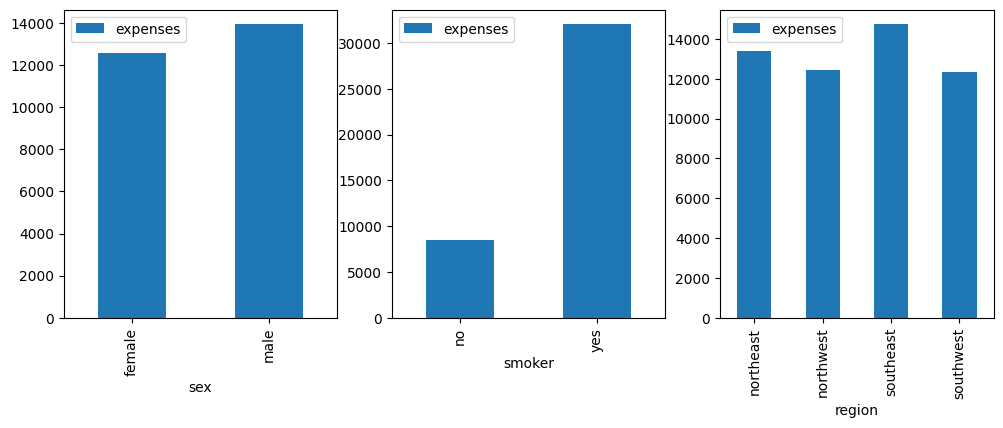

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
cols = [f for f in dataset.columns if dataset[f].dtype == 'object']
for i, feature in enumerate(cols):
  dataset[[feature, 'expenses']].groupby(feature).mean().plot(kind='bar', ax=axes[i])

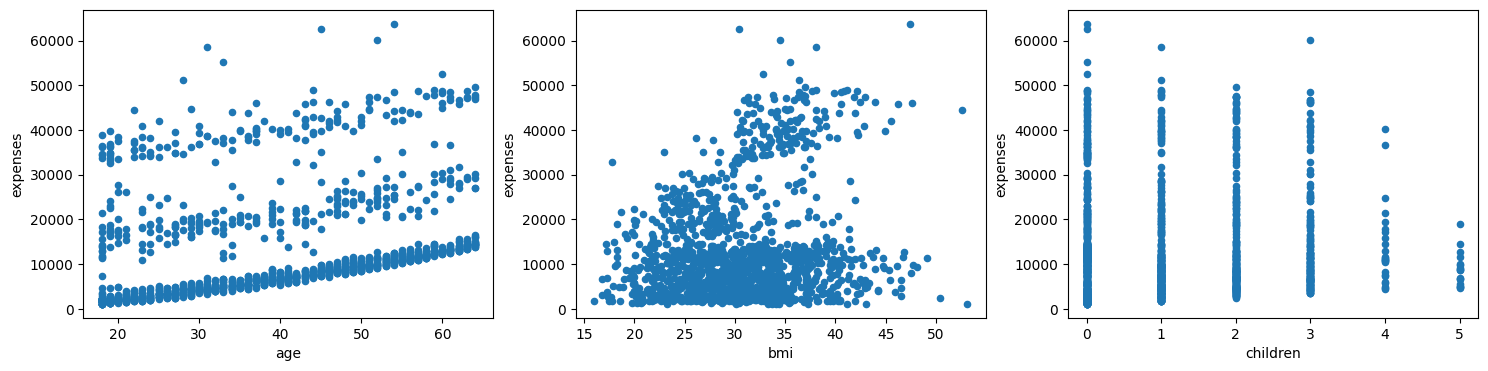

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
cols = [f for f in dataset.columns if f != 'expenses' and dataset[f].dtype != 'object']
for i, feature in enumerate(cols):
  dataset.plot.scatter(x=feature, y='expenses',ax=axes[i])

In [ ]:
df = dataset.copy()

In [ ]:
feature_columns = {}
for col_name in df.columns:
  if(df[col_name].dtype == 'object'):
    c = df[col_name].astype('category')
    df[col_name] = c.cat.codes
    feature_columns[col_name] = dict(enumerate(c.cat.categories))

In [ ]:
df.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,0,27.9,0,1,3,16884.92
1,18,1,33.8,1,0,2,1725.55
2,28,1,33.0,3,0,2,4449.46
3,33,1,22.7,0,0,1,21984.47
4,32,1,28.9,0,0,1,3866.86


In [ ]:
feature_columns

{'sex': {0: 'female', 1: 'male'},
 'smoker': {0: 'no', 1: 'yes'},
 'region': {0: 'northeast', 1: 'northwest', 2: 'southeast', 3: 'southwest'}}

In [ ]:
train_features = df.sample(frac=0.8, random_state=0)
test_features = df.drop(train_features.index)
train_dataset = train_features.copy()
test_dataset = test_features.copy()

train_labels = train_dataset.pop('expenses')
test_labels = test_dataset.pop('expenses')

In [ ]:
normalizer = layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_dataset))

In [ ]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=['mae', 'mse'])

  return model

In [ ]:
model = build_and_compile_model(normalizer)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (1070, 6)              │            13 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13 (56.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 13 (56.00 B)

In [ ]:
history = model.fit(
    train_dataset,
    train_labels,
    validation_split=0.2,
    verbose=1,
    epochs=600)

Epoch 1/600
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 12410.9414 - mae: 12410.9414 - mse: 290500480.0000 - val_loss: 14427.1885 - val_mae: 14427.1885 - val_mse: 363287168.0000
Epoch 2/600
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12885.6377 - mae: 12885.6377 - mse: 308027584.0000 - val_loss: 14422.8135 - val_mae: 14422.8115 - val_mse: 363152128.0000
Epoch 3/600
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12659.6230 - mae: 12659.6230 - mse: 293419552.0000 - val_loss: 14414.2197 - val_mae: 14414.2197 - val_mse: 362892352.0000
Epoch 4/600
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12192.5879 - mae: 12192.5879 - mse: 288000384.0000 - val_loss: 14398.9365 - val_mae: 14398.9365 - val_mse: 362436096.0000
Epoch 5/600
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12769.3926 - mae: 12769.3926 - mse: 305175040.0000 - val_loss: 14373.8574 - val_mae: 14373.8564 - val_mse: 361696128.0000
Epoch 6/600
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12615.3164 - mae: 12615.3164 - mse:

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')

  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

In [ ]:
plot_loss(history)

In [ ]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
